In [1249]:
import geopandas as gpd
from shapely.ops import cascaded_union
import xarray as xr
import salem
import sys
sys.path.append("/home/abhi/Documents/mygit/postBC_diagnostic/src/scripts")
from recipes import *
%matplotlib inline
from cftime import Datetime360Day
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from calendar import month_abbr
from cdo import Cdo
cdo = Cdo()
import _pickle as cpickle
import os
import re


In [1670]:
import cmocean

In [1469]:
def getFile(model, var, metric, seas=None):
    if metric in ['wetdayprecip_1mm', 'wetdayfreq_1mm'] or re.match(r'pd_[0-9]+mm', metric):
        metric_name, thresh = metric.split('_')
        return f"../data/{model}/{var}/{metric_name}/1971-2000_rm_ll25_{seas}_{metric_name}_{thresh}.nc"
    
    elif re.match(re.compile(r"[A|B|N]_[abs|anam]+"), metric) and var == 'precip':
        return f"../data/{model}/precip/ABN/1971-2000_rm_ll25_{metric}.nc"
    
    elif metric in ['monmean', 'ymonmean']:
        return f"../data/{model}/{var}/{metric}/1971-2000_rm_ll25_{metric}.nc"
    
    else:
        return f"../data/{model}/{var}/{metric}/1971-2000_rm_ll25_{seas}_{metric}.nc"


In [728]:
def getvarname(model, var):
    if model in ['IMD', 'PRECIS']:
        return {'precip': 'precip',
               'tmean': 'tmean',
               'tmax': 'tmax',
               'tmin': 'tmin'}[var]
    
    elif model == 'HADGEM2-ES':
        return {'precip': 'pr',
               'tmean': 'tas',
               'tmax': 'tasmax',
               'tmin': 'tasmin'}[var]

def gettimename(model, var):
    if ((model in ['IMD', 'HADGEM2-ES'])
        or
        (model == 'PRECIS') and (var == 'tmean')):
        
        return 'time'
    
    elif model == 'PRECIS':
        return 't'

In [129]:
mpl.style.use("seaborn")

In [2]:
shp = (gpd
       .read_file('/home/abhi/Documents/data/shapefiles/India_climatic_correct/India_climatic_correct.shp'))

shp = shp.loc[~shp.Region.str.startswith('Him'), :]

In [224]:
shp

,Region,geometry
0,Northern,"POLYGON ((74.69647216796902 37.09747314453151,..."
1,North East,"POLYGON ((96.07592773437526 29.45227050781277,..."
2,North West,"POLYGON ((78.66308593750018 32.09088134765651,..."
3,Central,"POLYGON ((79.07147216796913 31.44647216796909,..."
4,Inner Peninsular,"POLYGON ((77.9238064266911 22.36504369950693, ..."
5,West Coast,"POLYGON ((72.81860684424524 23.08328317338179,..."
6,East Coast,"POLYGON ((88.23954612524412 22.62552936501093,..."


In [227]:
shp_ind = gpd.read_file("/home/abhi/Documents/data/shapefiles/india_shp/India.shp")

shp_ind = gpd.GeoDataFrame(shp_ind['geometry'])

shp_ind['Region'] = pd.Series(['India'])
shp_ind = gpd.GeoDataFrame(shp_ind, geometry='geometry')

In [229]:
pd.concat([shp, shp_ind], axis=0, ignore_index=True)

/home/abhi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Region,geometry
0,Northern,"POLYGON ((74.69647216796902 37.09747314453151,..."
1,North East,"POLYGON ((96.07592773437526 29.45227050781277,..."
2,North West,"POLYGON ((78.66308593750018 32.09088134765651,..."
3,Central,"POLYGON ((79.07147216796913 31.44647216796909,..."
4,Inner Peninsular,"POLYGON ((77.9238064266911 22.36504369950693, ..."
5,West Coast,"POLYGON ((72.81860684424524 23.08328317338179,..."
6,East Coast,"POLYGON ((88.23954612524412 22.62552936501093,..."
7,India,(POLYGON ((93.78772700120021 6.852639999336532...


In [208]:
gpd.GeoDataFrame.from_dict({'Region': 'Core Monsoon',
                   'geometry': mzi_points}, )

TypeError: from_dict() got an unexpected keyword argument 'index'

In [210]:
from shapely.geometry import Polygon

mzi_points = Polygon([(73, 18), (73, 28), (82, 28), (82, 18)])

shp_cmr = pd.DataFrame({'Region': 'Core Monsoon',
                   'geometry': mzi_points}, index = [0])

In [232]:
shp_cmr = gpd.GeoDataFrame(shp_cmr, geometry='geometry')

In [256]:
shp_all = pd.concat([shp, shp_cmr, shp_ind], ignore_index=True)

/home/abhi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [257]:
shp_all = gpd.GeoDataFrame(shp_all, geometry='geometry')

In [258]:
shp_all

,Region,geometry
0,Northern,"POLYGON ((74.69647216796902 37.09747314453151,..."
1,North East,"POLYGON ((96.07592773437526 29.45227050781277,..."
2,North West,"POLYGON ((78.66308593750018 32.09088134765651,..."
3,Central,"POLYGON ((79.07147216796913 31.44647216796909,..."
4,Inner Peninsular,"POLYGON ((77.9238064266911 22.36504369950693, ..."
5,West Coast,"POLYGON ((72.81860684424524 23.08328317338179,..."
6,East Coast,"POLYGON ((88.23954612524412 22.62552936501093,..."
7,Core Monsoon,"POLYGON ((73 18, 73 28, 82 28, 82 18, 73 18))"
8,India,(POLYGON ((93.78772700120021 6.852639999336532...


In [12]:
data_dir = "/home/abhi/Documents/data"
fpaths = {}
fpaths['IMD'] = f"{data_dir}/OBSERVATION/IMD/precip/1971-2000_rm_ll25_360day.nc"
fpaths['PRECIS'] = f"{data_dir}/PRECIS/base/precip/1971-2000_rm_ll25.nc"
fpaths['HADGEM2-ES'] = f"../data/HADGEM2-ES/precip/daymean/pr_day_HadGEM2-ES_historical_r1i1p1_19710101-20001230.nc"

In [174]:
def subsetbygdf(ds, gdf, region_col, apply_fldmean=True):
    
    regionIndex = gdf[region_col]
    regionIndex.name = 'region'
    if apply_fldmean:
        return xr.concat([fldmean(ds.salem.roi(shape=gdf.loc[gdf.index == index], 
                                              all_touched=True))
                         for index in gdf.index],
                        dim=regionIndex)
    
    else: 
        pass

In [280]:
def subsetbygdf_new(ds, gdf, region_col, apply_fldmean=True):
    
    regionIndex = gdf[region_col]
    if apply_fldmean:
        objs = [fldmean(ds.salem.roi(shape=gdf.loc[gdf.index == index], 
                                              all_touched=True))
                         for index in gdf.index]
        
        regionIndex = pd.concat(
            [regionIndex, pd.Series(['Core Monsoon', 'India'])], ignore_index=True)
        regionIndex.name = 'region'
        
        objs.append(fldmean(sellonlatbox(ds, [73, 82, 18, 28])))
        objs.append(fldmean(ds))
        
        return xr.concat(objs,
                        dim=regionIndex)
    
    else: 
        pass

In [286]:
def getModelFile(model, var):
    data_dir = "/home/abhi/Documents/data"

    if model == 'IMD':
        return f"{data_dir}/OBSERVATION/IMD/{var}/1971-2000_rm_ll25_360day.nc"
    
    elif model == 'PRECIS':
        return f"{data_dir}/PRECIS/base/{var}/1971-2000_rm_ll25.nc"
    
    elif model == 'HADGEM2-ES':
        return f"../data/HADGEM2-ES/{var}/daymean/{getvarname(model, var)}"+\
                "_day_HadGEM2-ES_historical_r1i1p1_19710101-20001230.nc"

In [13]:
def getvarname(model, var):
    if model in ['IMD', 'PRECIS']:
        return {'precip': 'precip',
               'tmean': 'tmean',
               'tmax': 'tmax',
               'tmin': 'tmin'}[var]
    
    elif model == 'HADGEM2-ES':
        return {'precip': 'pr',
               'tmean': 'tas',
               'tmax': 'tasmax',
               'tmin': 'tasmin'}[var]

def gettimename(model, var):
    if ((model in ['IMD', 'HADGEM2-ES'])
        or
        (model == 'PRECIS') and (var == 'tmean')):
        
        return 'time'
    
    elif model == 'PRECIS':
         return 't'

In [14]:
modelIndex = pd.Index(['IMD', 'PRECIS', 'HADGEM2-ES'], name='model')

In [79]:
### Extract time index
ti = xr.open_dataset(fpaths['HADGEM2-ES'])['time']

In [80]:
ti.name = 'time'

In [81]:
ti

<xarray.DataArray 'time' (time: 10800)>
array([cftime.Datetime360Day(1971, 1, 1, 12, 0, 0, 0, 5, 1),
       cftime.Datetime360Day(1971, 1, 2, 12, 0, 0, 0, 6, 2),
       cftime.Datetime360Day(1971, 1, 3, 12, 0, 0, 0, 0, 3), ...,
       cftime.Datetime360Day(2000, 12, 28, 12, 0, 0, 0, 1, 358),
       cftime.Datetime360Day(2000, 12, 29, 12, 0, 0, 0, 2, 359),
       cftime.Datetime360Day(2000, 12, 30, 12, 0, 0, 0, 3, 360)], dtype=object)
Coordinates:
  * time     (time) object 1971-01-01 12:00:00 ... 2000-12-30 12:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

### India fld-mean Annual cycle boxplots

In [15]:
var = 'precip'

In [16]:
%%time
fmean_ind_ds = xr.concat([fldmean(xr
                                  .open_dataset(fpaths[model])
                                 .rename({gettimename(model, var): 'time'}))[getvarname(model, var)]
                         for model in modelIndex],
                        dim=modelIndex)

CPU times: user 10.1 s, sys: 3.56 s, total: 13.6 s
Wall time: 28.4 s


In [60]:
xr.set_options(enable_cftimeindex=True)

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/options.py:49: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  FutureWarning)


In [451]:
objs = []
var = 'precip'

def getModelCombinedObjs(var, ):
    objs = []
    for model in modelIndex:
        rename_dict = {gettimename(model, var): 'time',
                      getvarname(model, var): var}
        
        ds = xr.open_dataset(getModelFile(model, var), 
                                             chunks={gettimename(model, var): 360})
        
        if var != 'precip':
            too_less =  ds[getvarname(model, var)] > -60
            too_much =  ds[getvarname(model, var)] < 60

            ds[getvarname(model, var)] =  ds[getvarname(model, var)].where(too_less & too_much)
        
        if (model == 'HADGEM2-ES') and (var == 'tmax'):
            ds = ds.reindex({gettimename(model, var): ti})
            
        ds = subsetbygdf_new(ds.rename(rename_dict)[var], 
                             shp, 'Region')
                         
        
        ds['time'] = ti
        
        try:
            ds = ds.drop('height')
        except Exception:
            pass
        


        objs.append(ds)
        
    return objs

In [452]:
modvar_combined = {}

In [447]:
varIndex = pd.Index(['precip', 'tmean', 'tmax', 'tmin'], name='var_name')

In [422]:
%%time
tmax_objs = getModelCombinedObjs('tmax')

CPU times: user 7.96 s, sys: 64 ms, total: 8.02 s
Wall time: 8.01 s


In [424]:
tmax_objs[0].sel(region='India').max(dim='time').compute()

<xarray.DataArray 'tmax' ()>
array(40.750416, dtype=float32)
Coordinates:
    region   <U5 'India'

In [453]:
%%time
for var in varIndex:
    modvar_combined[var] = getModelCombinedObjs(var)

CPU times: user 32.8 s, sys: 260 ms, total: 33 s
Wall time: 33 s


In [455]:
modvar_combined

dict_keys(['precip', 'tmean', 'tmax', 'tmin'])

In [458]:
allvar_combined = {var: xr.concat(dsets, dim=modelIndex) 
                   for var, dsets in modvar_combined.items()}

In [461]:
combined_ds = xr.concat(allvar_combined.values(), dim=varIndex)

In [476]:
combined_ds.name = 'variable'

In [477]:
!mkdir -p ../pickles/Analysis-Annual-cycle/

In [478]:
with open("../pickles/Analysis-Annual-cycle/combined_fldmean_ds.pkl", "wb") as f:
    cpickle.dump(combined_ds, f)

In [152]:
fldmean_ind_ds = xr.concat(objs, dim=modelIndex).to_dataset()

In [153]:
fmean_ind_ds

<xarray.Dataset>
Dimensions:  (model: 3, time: 21600)
Coordinates:
  * time     (time) object 1971-01-01 00:00:00 ... 2000-12-30 12:00:00
  * model    (model) object 'IMD' 'PRECIS' 'HADGEM2-ES'
Data variables:
    precip   (model, time) float32 0.021556903 nan 0.08958224 ... nan 1.4998912

In [154]:
df = fmean_ind_ds.to_dataframe().reset_index().dropna()

In [110]:
cft = df.time[0]

In [89]:
Datetime360Day(2000, 1, 1).hour

0

In [155]:
def conv2pd_dt(cft_obj):
    try:
        return pd.datetime(year=cft_obj.year, month=cft_obj.month, day=cft_obj.day)
    except Exception:
        return np.nan

In [156]:
conv2pd_dt(cft)

datetime.datetime(1971, 1, 1, 0, 0)

In [157]:
df.time = df.time.apply(lambda x: conv2pd_dt(x))


In [158]:
df.dropna(inplace=True)

In [159]:
df['month'] = df.time.dt.month

In [1596]:
titles = {'precip': 'Precipitation (mm $d^{-1}$)',
         'tmean': 'Mean Temperature ($^\circ$C)',
         'tmax': 'Max Temperature ($^\circ$C)',
         'tmin': 'Min Temperature ($^\circ$C)'}

In [1025]:
def_cols = ['gray', 'steelblue', 'crimson']

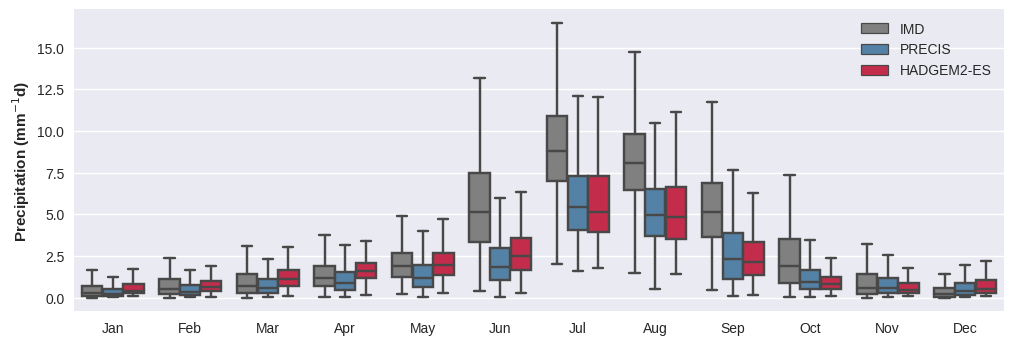

In [361]:
fig, ax = plt.subplots(dpi=100, figsize=(12, 4))
sns.boxplot(data=df, x='month', y='precip', hue='model', showfliers=False, ax=ax, 
           palette=['gray', 'steelblue', 'crimson'])
mon_labels = ax.set_xticklabels(month_abbr[1:])
ax.set_xlabel('')
ax.set_ylabel(titles['precip'], fontweight='bold')
ax.legend().set_title('')

In [146]:
df_clim = df.groupby(['month', 'model']).mean().reset_index()

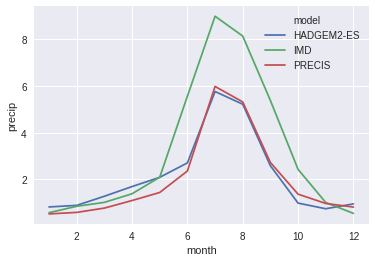

In [149]:
sns.lineplot(data=df_clim, x='month', y='precip', hue='model')

In [1088]:
df_clim = (combined_df
           .groupby(['var_name', 'model', 'region', 'month'])
           .variable
           .agg(['mean', 'std'])).reset_index()

In [1604]:
def sel_df2(var_name, model, region, stat):
    cond_dict = {}
    
    for cond in ['var_name', 'model', 'region']:
        cond_dict[cond] = (df_climday[cond] == eval(cond))
        
    all_cond = (cond_dict['var_name'] &
               cond_dict['model'] &
               cond_dict['region'])
    
    return df_climday.loc[all_cond, stat]

In [1590]:
combined_df['doy'] = combined_df.time.dt.dayofyear

In [1592]:
df_climday = (combined_df
           .groupby(['var_name', 'model', 'region', 'doy'])
           .variable
           .agg(['mean', 'std'])).reset_index()

In [1593]:
df_climday.head()

,var_name,model,region,doy,mean,std
0,precip,HADGEM2-ES,Central,1,0.615128,0.725544
1,precip,HADGEM2-ES,Central,2,0.633352,0.645691
2,precip,HADGEM2-ES,Central,3,1.019263,1.628780
3,precip,HADGEM2-ES,Central,4,1.255011,1.874208
4,precip,HADGEM2-ES,Central,5,1.058697,1.508095


In [1612]:
var, region = 'tmean', 'North West'


def plot_annualcycle(var, region, savefig=False):
    fig, ax = plt.subplots(figsize=(12, 4))


    for model in modelIndex:
        df_mean = sel_df2(var, model, region, 'mean')
        df_std = sel_df2(var, model, region, 'std')
        
        X = range(1, df_mean.size+1)
        ax.plot(X, df_mean, 
                color=def_cols_d[model], label=model)

        ax.set_ylabel(titles[var])
        ax.set_title(region, fontsize=16, fontweight='bold')
    #     ax.fill_between(month_abbr[1:], 
    #                    df_mean - df_std,
    #                    df_mean + df_std, 
    #                    color=def_cols_d[model], alpha=0.2)

    #     ax.plot(month_abbr[1:], df_mean+ df_std, 
    #             color=def_cols_d[model], linestyle='--')


    ax.legend()

    if savefig:
        outdir = f"../plots/compare/{var}/Annual-cycle"
        os.system(f'mkdir -p {outdir}')
        fig.savefig(f"{outdir}/{region}.png", dpi=400,
                   bbox_inches='tight')
        plt.close(fig)

In [1609]:
sel_df2('precip', 'PRECIS', 'India', 'mean').size

364

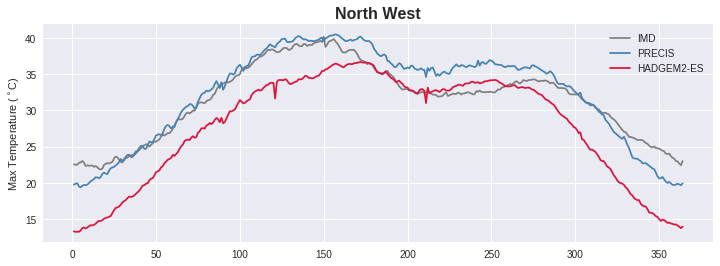

In [1617]:
plot_annualcycle('tmax', 'North West', )

In [1539]:
%%time
for var in ['precip']:
    for region in regionIndex_new:
        
        plot_annualcycle(var, region, savefig=True)

CPU times: user 21 s, sys: 3 s, total: 24 s
Wall time: 21.4 s


In [1084]:
df_clim

mean       std
var_name model      region       month                     
precip   HADGEM2-ES Central      1.0     1.035037  2.040484
                                 2.0     0.981077  1.893731
                                 3.0     0.851131  1.260296
                                 4.0     0.905241  0.991142
                                 5.0     1.437223  1.550688
                                 6.0     1.726755  2.061224
                                 7.0     7.882404  5.160526
                                 8.0     6.986609  4.392251
                                 9.0     2.657784  3.384323
                                 10.0    0.539975  0.798370
                                 11.0    0.669348  1.356126
                                 12.0    1.293838  2.279520
                    Core Monsoon 1.0     0.509329  1.160029
                                 2.0     0.379744  0.919826
                                 3.0     0.226840  0.450570
                                 4.0     0.275186  0.441171
                                 5.0     0.483516  0.731092
                                 6.0     0.366647  0.785098
                                 7.0     3.501839  4.023460
                                 8.0     3.490044  3.791182
                                 9.0     1.203569  2.471117
                                 10.0    0.424562  0.737758
                                 11.0    0.366415  0.858876
                                 12.0    0.708643  1.452829
                    East Coast   1.0     0.646496  1.882699
                                 2.0     0.424160  0.940849
                                 3.0     0.341958  0.872358
                                 4.0     0.560357  0.776521
                                 5.0     0.608428  0.847529
                                 6.0     0.642637  1.564368
...                                           ...       ...
tmin     PRECIS     North West   7.0    25.588875  0.798854
                                 8.0    24.781881  0.785286
                                 9.0    21.593540  2.386755
                                 10.0   15.328747  2.513612
                                 11.0    9.785517  2.973377
                                 12.0    3.827989  3.344334
                    Northern     1.0   -26.049524  4.850324
                                 2.0   -22.628502  4.573483
                                 3.0   -17.607038  4.567586
                                 4.0   -13.107714  3.783508
                                 5.0    -7.544303  2.823427
                                 6.0    -2.099827  2.383157
                                 7.0     1.854699  1.725120
                                 8.0     1.010670  1.959979
                                 9.0    -5.026993  2.832867
                                 10.0  -12.063732  2.949148
                                 11.0  -18.299358  4.300660
                                 12.0  -23.821497  5.100419
                    West Coast   1.0    14.431381  1.631077
                                 2.0    15.001630  1.459236
                                 3.0    17.453915  1.496856
                                 4.0    20.270910  1.286537
                                 5.0    21.524818  0.774294
                                 6.0    22.521532  0.725633
                                 7.0    23.086468  0.404941
                                 8.0    22.590179  0.468628
                                 9.0    20.910074  1.092174
                                 10.0   20.599785  1.057480
                                 11.0   18.640553  1.717993
                                 12.0   15.935536  2.163036

[1296 rows x 2 columns]

In [1079]:
df_climstd = df.groupby(['month', 'model']).mean().reset_index()

,month,model,precip
0,1,HADGEM2-ES,0.824659
1,1,IMD,0.579823
2,1,PRECIS,0.526405
3,2,HADGEM2-ES,0.891499
4,2,IMD,0.852803
5,2,PRECIS,0.591482
6,3,HADGEM2-ES,1.281998
7,3,IMD,1.020326
8,3,PRECIS,0.775534
9,4,HADGEM2-ES,1.696429


In [281]:
%%time
test = subsetbygdf_new(xr.open_dataset(getModelFile('IMD', 'precip')), shp, 'Region')

CPU times: user 13.5 s, sys: 6.44 s, total: 19.9 s
Wall time: 20 s


In [279]:
test


<xarray.Dataset>
Dimensions:     (concat_dim: 9, time: 10800)
Coordinates:
  * time        (time) object 1971-01-01 00:00:00 ... 2000-12-30 00:00:00
  * concat_dim  (concat_dim) object 'Northern' 'North East' ... 'India'
Data variables:
    precip      (concat_dim, time) float32 0.0 0.0 0.0 ... 0.99462074 0.38607562

In [262]:
ind = fldmean(xr.open_dataset(getModelFile('IMD', 'precip')))

In [266]:
regionIndex = shp['Region']
regionIndex.name = 'region'

In [272]:
regionIndex

0            Northern
1          North East
2          North West
3             Central
4    Inner Peninsular
5          West Coast
6          East Coast
Name: region, dtype: object

In [569]:
regionIndex_new = pd.concat([regionIndex, pd.Series(['Core Monsoon', 'India'])], ignore_index=True)

In [484]:
combined_ds_c = combined_ds.compute()

/home/abhi/miniconda3/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/abhi/miniconda3/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/abhi/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [486]:
combined_ds_c

<xarray.DataArray 'variable' (var_name: 4, model: 3, region: 9, time: 10800)>
array([[[[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [ 2.155690e-02, ...,  3.860756e-01]],

        ...,

        [[ 8.477128e-02, ...,  7.548818e+00],
         ...,
         [ 1.303605e-01, ...,  1.499891e+00]]],


       ...,


       [[[-2.880047e+00, ...,  2.193188e+00],
         ...,
         [ 7.663945e+00, ...,  1.099713e+01]],

        ...,

        [[-2.278127e+01, ..., -1.606509e+01],
         ...,
         [ 4.439870e+00, ...,  8.255291e+00]]]], dtype=float32)
Coordinates:
  * time      (time) object 1971-01-01 12:00:00 ... 2000-12-30 12:00:00
  * region    (region) object 'Northern' 'North East' ... 'Core Monsoon' 'India'
  * model     (model) object 'IMD' 'PRECIS' 'HADGEM2-ES'
  * var_name  (var_name) object 'precip' 'tmean' 'tmax' 'tmin'

In [485]:
with open("../pickles/Analysis-Annual-cycle/combined_fldmean_ds_c.pkl", "wb") as f:
    cpickle.dump(combined_ds_c, f)

In [490]:
%%time
combined_df = combined_ds_c.to_dataframe().reset_index()

CPU times: user 196 ms, sys: 28 ms, total: 224 ms
Wall time: 221 ms


In [494]:
combined_df.time = combined_df.time.apply(conv2pd_dt)

In [497]:
combined_df['month'] = combined_df.time.dt.month 

In [523]:
combined_df.dropna(inplace=True)

In [1507]:
def sel_df(var_name, region):
    var_cond = (combined_df.var_name == var_name)
    
    region_cond = np.isin(combined_df.region, region)
    
    return combined_df.loc[var_cond & region_cond, :]

In [510]:
combined_df.region.unique()

array(['Northern', 'North East', 'North West', 'Central',
       'Inner Peninsular', 'West Coast', 'East Coast', 'Core Monsoon',
       'India'], dtype=object)

In [1040]:
df.head()

,var_name,model,region,time,variable,month,seas
378000,tmean,IMD,India,1971-01-01,16.400925,1.0,DJF
378001,tmean,IMD,India,1971-01-02,15.879515,1.0,DJF
378002,tmean,IMD,India,1971-01-03,16.385227,1.0,DJF
378003,tmean,IMD,India,1971-01-04,16.796783,1.0,DJF
378004,tmean,IMD,India,1971-01-05,16.923214,1.0,DJF


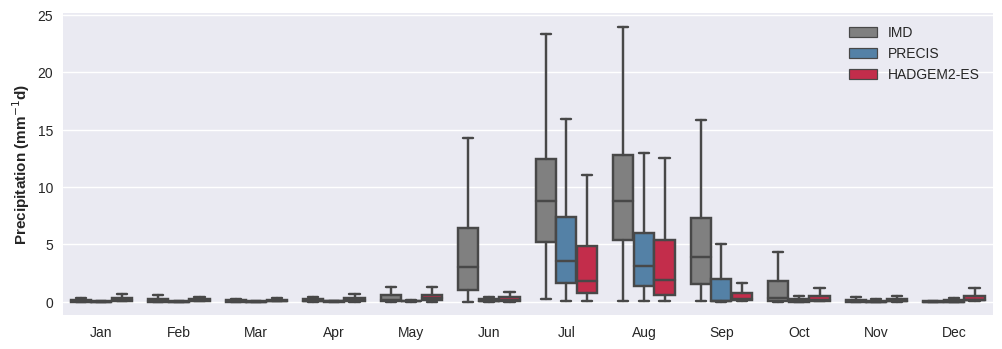

In [1500]:
var_name = 'precip'
region = 'Core Monsoon'

df = sel_df(var_name, region)

fig, ax = plt.subplots(dpi=100, figsize=(12, 4))
sns.boxplot(data=df, x='month', y='variable', hue='model', showfliers=False, ax=ax, 
           palette=['gray', 'steelblue', 'crimson'])
mon_labels = ax.set_xticklabels(month_abbr[1:])
ax.set_xlabel('')
ax.set_ylabel(titles[var_name], fontweight='bold')
ax.legend().set_title('')

In [517]:
seas_dict =     {'JJAS': [6, 7, 8, 9],
                 'ON': [10 , 11],
                'DJF': [12, 1, 2],
                'MAM': [3, 4, 5]}

In [518]:
def getseas(month):
    for seas, monlist in seas_dict.items():
        if month in monlist:
            return seas
    
    

In [524]:
combined_df['seas'] = combined_df.month.apply(getseas)

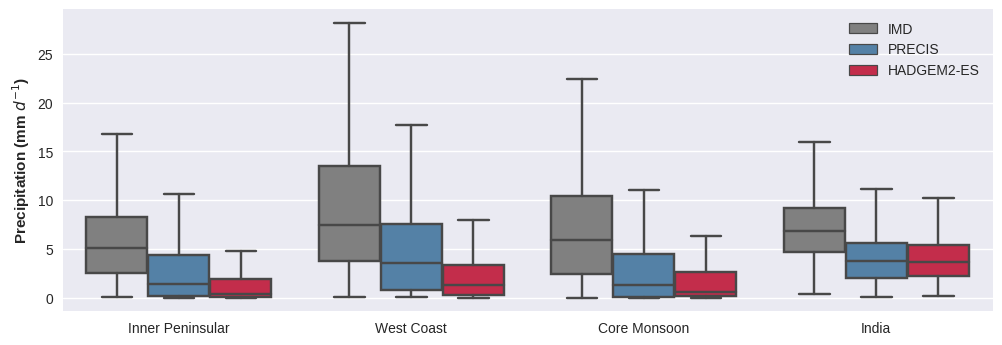

In [1540]:
var_name = 'precip'
# region = 'West Coast'
regions = ['India', 'Core Monsoon',
                      'West Coast', 'Inner Peninsular']
seas = 'JJAS'
df = sel_df(var_name, regions)
df = df.loc[df.seas == seas]

fig, ax = plt.subplots(dpi=100, figsize=(12, 4))
plot = sns.boxplot(data=df, x='region', y='variable', hue='model', showfliers=False, ax=ax, 
           palette=['gray', 'steelblue', 'crimson'])
# mon_labels = ax.set_xticklabels(month_abbr[1:])
ax.set_xlabel('')
ax.set_ylabel(titles[var_name], fontweight='bold')
ax.legend().set_title('')

out_dir = f"../plots/compare/{var_name}/boxplots"
os.system(f"mkdir -p {out_dir}")
plot.figure.savefig(f"{out_dir}/{'_'.join(regions)}_{seas}.png",
                dpi=400, bbox_inches='tight')

In [1517]:
out_dir

'../plots/compare/precip/boxplots'

In [826]:
combined_df.groupby(['seas', 'region','var_name', 'model']).variable.mean()

seas  region        var_name  model     
DJF   Central       precip    HADGEM2-ES     1.105718
                              IMD            0.434477
                              PRECIS         0.457454
                    tmax      HADGEM2-ES    18.040325
                              IMD           24.978699
                              PRECIS        23.868626
                    tmean     HADGEM2-ES    12.080367
                              IMD           17.337347
                              PRECIS        14.156499
                    tmin      HADGEM2-ES     6.242962
                              IMD            9.695940
                              PRECIS         5.308788
      Core Monsoon  precip    HADGEM2-ES     0.535573
                              IMD            0.250603
                              PRECIS         0.218883
                    tmax      HADGEM2-ES    23.143652
                              IMD           27.214462
                              PRECIS     

,var_name,model,region,time,variable,month,seas
0,precip,IMD,Northern,1971-01-01,0.000000,1.0,DJF
1,precip,IMD,Northern,1971-01-02,0.000000,1.0,DJF
2,precip,IMD,Northern,1971-01-03,0.000000,1.0,DJF
3,precip,IMD,Northern,1971-01-04,0.000000,1.0,DJF
4,precip,IMD,Northern,1971-01-05,0.000000,1.0,DJF
5,precip,IMD,Northern,1971-01-06,0.000000,1.0,DJF
6,precip,IMD,Northern,1971-01-07,0.337511,1.0,DJF
7,precip,IMD,Northern,1971-01-08,0.165058,1.0,DJF
8,precip,IMD,Northern,1971-01-09,0.000000,1.0,DJF
9,precip,IMD,Northern,1971-01-10,0.000000,1.0,DJF


In [827]:
combined_df.groupby(['var_name', 'region', 'model']).variable.describe()

count       mean        std  \
var_name region           model                                       
precip   Central          HADGEM2-ES  10748.0   2.253328   3.545191   
                          IMD         10748.0   2.913279   4.877775   
                          PRECIS      10748.0   1.631506   3.183608   
         Core Monsoon     HADGEM2-ES  10748.0   0.997673   2.230632   
                          IMD         10748.0   2.616619   4.494337   
                          PRECIS      10748.0   1.145052   2.959764   
         East Coast       HADGEM2-ES  10748.0   1.348096   2.694990   
                          IMD         10748.0   3.340288   4.596957   
                          PRECIS      10748.0   2.025850   4.556166   
         India            HADGEM2-ES  10748.0   2.151964   2.132552   
                          IMD         10748.0   3.176616   3.453485   
                          PRECIS      10748.0   2.005119   2.350498   
         Inner Peninsular HADGEM2-ES  10748.0   0.864139   2.145346   
                          IMD         10748.0   2.596221   3.889280   
                          PRECIS      10748.0   1.404262   3.564894   
         North East       HADGEM2-ES  10748.0   5.824118   6.085293   
                          IMD         10748.0   5.853519   6.935573   
                          PRECIS      10748.0   4.777733   5.453840   
         North West       HADGEM2-ES  10748.0   1.046776   1.746382   
                          IMD         10748.0   1.500172   3.108036   
                          PRECIS      10748.0   0.512227   1.280834   
         Northern         HADGEM2-ES  10748.0   2.888195   2.732666   
                          IMD         10748.0   2.665097   5.089244   
                          PRECIS      10748.0   2.281215   3.206133   
         West Coast       HADGEM2-ES  10748.0   1.004086   2.089047   
                          IMD         10748.0   4.099380   6.633994   
                          PRECIS      10748.0   2.094661   3.685714   
tmax     Central          HADGEM2-ES  10407.0  27.210472   6.929998   
                          IMD         10748.0  31.550257   5.286817   
                          PRECIS      10748.0  31.850044   6.552628   
...                                       ...        ...        ...   
tmean    West Coast       HADGEM2-ES  10748.0  26.077799   2.298260   
                          IMD         10748.0  25.885553   2.344806   
                          PRECIS      10748.0  24.891102   2.248443   
tmin     Central          HADGEM2-ES  10748.0  15.844198   7.756622   
                          IMD         10748.0  18.454504   6.420942   
                          PRECIS      10748.0  15.749018   8.005236   
         Core Monsoon     HADGEM2-ES  10748.0  17.382534   7.089697   
                          IMD         10748.0  19.204834   5.713135   
                          PRECIS      10748.0  17.058613   6.865425   
         East Coast       HADGEM2-ES  10748.0  21.735033   4.400187   
                          IMD         10748.0  22.420176   3.418725   
                          PRECIS      10748.0  20.799572   4.742040   
         India            HADGEM2-ES  10748.0  14.775386   6.508060   
                          IMD         10748.0  18.618572   5.220311   
                          PRECIS      10748.0  14.058372   6.629133   
         Inner Peninsular HADGEM2-ES  10748.0  18.860270   5.023081   
                          IMD         10748.0  20.429470   3.909136   
                          PRECIS      10748.0  18.470690   4.796437   
         North East       HADGEM2-ES  10748.0  13.822627   6.817426   
                          IMD         10748.0  18.833570   5.472816   
                          PRECIS      10748.0  14.532756   7.215105   
         North West       HADGEM2-ES  10748.0  15.463981   8.315459   
                          IMD         10748.0  17.855785   6.831431   
                          PRECIS      10748.0  15.238786   8.699

In [555]:
combined_ds_c = combined_ds_c.to_dataset()

In [556]:
combined_ds_c

<xarray.Dataset>
Dimensions:   (model: 3, region: 9, time: 10800, var_name: 4)
Coordinates:
  * time      (time) object 1971-01-01 12:00:00 ... 2000-12-30 12:00:00
  * region    (region) object 'Northern' 'North East' ... 'Core Monsoon' 'India'
  * model     (model) object 'IMD' 'PRECIS' 'HADGEM2-ES'
  * var_name  (var_name) object 'precip' 'tmean' 'tmax' 'tmin'
Data variables:
    variable  (var_name, model, region, time) float32 0.0 0.0 ... 8.255291

In [588]:
nc_IMD = (combined_ds_c.sel(model='IMD', region='India', var_name='precip')
          .rename({'variable': 'India_precip'})).drop(['region', 'model', 'var_name'])

In [568]:
regionIndex

0            Northern
1          North East
2          North West
3             Central
4    Inner Peninsular
5          West Coast
6          East Coast
Name: region, dtype: object

In [589]:
ncfiles = {}

In [590]:
for model in modelIndex:
    ncfiles[model] = nc_IMD.copy()
    
    for var in varIndex:
        for region in regionIndex_new:
            assign_varname = f"{region}_{var}"
            
            assign_da = (combined_ds_c.sel(model=model, 
                                           region=region, 
                                           var_name=var)
                         .rename({'variable': assign_varname}).drop(['region', 'model', 'var_name']))
            
            ncfiles[model] = ncfiles[model].assign({assign_varname: assign_da[assign_varname]})

In [592]:
for model, _ds in ncfiles.items():
    _ds.to_netcdf(f"/tmp/{model}_rf.nc")

In [637]:
timcor_dict = {model: xr.open_dataset(cdo.timcor(input=f"-yearmean /tmp/IMD_rf.nc -yearmean /tmp/{model}_rf.nc", 
                                                returnCDF=True))
              for model in ['PRECIS', 'HADGEM2-ES']}

In [638]:
timcor_ds = xr.concat(timcor_dict.values(), dim=pd.Index(['PRECIS', 'HADGEM2-ES'], 
                                                         name='model')).mean('time')

In [639]:
region_ds = {}

In [640]:
timcor_ds

<xarray.Dataset>
Dimensions:                  (bnds: 2, model: 2)
Coordinates:
  * model                    (model) object 'PRECIS' 'HADGEM2-ES'
Dimensions without coordinates: bnds
Data variables:
    time_bnds                (model, bnds) float64 -6.696e+05 ... -6.696e+05
    India_precip             (model) float32 0.11172817 0.13199578
    Northern_precip          (model) float32 -0.1435686 -0.09269663
    North East_precip        (model) float32 0.174835 0.2865479
    North West_precip        (model) float32 0.0863386 -0.018128937
    Central_precip           (model) float32 0.2659536 0.023838518
    Inner Peninsular_precip  (model) float32 0.033153556 0.17227422
    West Coast_precip        (model) float32 0.053939983 0.09556917
    East Coast_precip        (model) float32 0.11467318 0.3335867
    Core Monsoon_precip      (model) float32 0.09830051 0.04560971
    Northern_tmean           (model) float32 0.39705816 0.6215064
    North East_tmean         (model) float32 0.37294462 

In [623]:
dict(zip(list(regionIndex_new + '_precip'), 
         list(regionIndex_new)))

{'Northern_precip': 'Northern',
 'North East_precip': 'North East',
 'North West_precip': 'North West',
 'Central_precip': 'Central',
 'Inner Peninsular_precip': 'Inner Peninsular',
 'West Coast_precip': 'West Coast',
 'East Coast_precip': 'East Coast',
 'Core Monsoon_precip': 'Core Monsoon',
 'India_precip': 'India'}

In [641]:
for var in varIndex:
    rename_dict = dict(zip(list(regionIndex_new + f'_{var}'), 
                    list(regionIndex_new)))
    
    region_ds[var] = (timcor_ds[list(regionIndex_new + f'_{var}')]
                      .rename(rename_dict))

    

In [642]:
region_ds

{'precip': <xarray.Dataset>
 Dimensions:           (model: 2)
 Coordinates:
   * model             (model) object 'PRECIS' 'HADGEM2-ES'
 Data variables:
     Northern          (model) float32 -0.1435686 -0.09269663
     North East        (model) float32 0.174835 0.2865479
     North West        (model) float32 0.0863386 -0.018128937
     Central           (model) float32 0.2659536 0.023838518
     Inner Peninsular  (model) float32 0.033153556 0.17227422
     West Coast        (model) float32 0.053939983 0.09556917
     East Coast        (model) float32 0.11467318 0.3335867
     Core Monsoon      (model) float32 0.09830051 0.04560971
     India             (model) float32 0.11172817 0.13199578,
 'tmean': <xarray.Dataset>
 Dimensions:           (model: 2)
 Coordinates:
   * model             (model) object 'PRECIS' 'HADGEM2-ES'
 Data variables:
     Northern          (model) float32 0.39705816 0.6215064
     North East        (model) float32 0.37294462 0.31791568
     North West        (

In [643]:
combined_tcor_ds = xr.concat(region_ds.values(), dim=varIndex)

In [644]:
combined_tcor_df = combined_tcor_ds.to_dataframe()

In [836]:
!mkdir -p ../csv/Analysis-Annual-Cycle

In [838]:
(combined_tcor_df.reorder_levels(['var_name', 'model']).sort_index().drop('Northern', axis=1)
 .to_csv('../csv/Analysis-Annual-Cycle/Region_var_model_tcor.csv'))

In [579]:
grp_obj = combined_df.groupby(['var_name', 'region', 'model']).variable

In [652]:
grp_obj.describe()[['mean', 'std']]

mean        std
var_name region           model                           
precip   Central          HADGEM2-ES   2.253328   3.545191
                          IMD          2.913279   4.877775
                          PRECIS       1.631506   3.183608
         Core Monsoon     HADGEM2-ES   0.997673   2.230632
                          IMD          2.616619   4.494337
                          PRECIS       1.145052   2.959764
         East Coast       HADGEM2-ES   1.348096   2.694990
                          IMD          3.340288   4.596957
                          PRECIS       2.025850   4.556166
         India            HADGEM2-ES   2.151964   2.132552
                          IMD          3.176616   3.453485
                          PRECIS       2.005119   2.350498
         Inner Peninsular HADGEM2-ES   0.864139   2.145346
                          IMD          2.596221   3.889280
                          PRECIS       1.404262   3.564894
         North East       HADGEM2-ES   5.824118   6.085293
                          IMD          5.853519   6.935573
                          PRECIS       4.777733   5.453840
         North West       HADGEM2-ES   1.046776   1.746382
                          IMD          1.500172   3.108036
                          PRECIS       0.512227   1.280834
         Northern         HADGEM2-ES   2.888195   2.732666
                          IMD          2.665097   5.089244
                          PRECIS       2.281215   3.206133
         West Coast       HADGEM2-ES   1.004086   2.089047
                          IMD          4.099380   6.633994
                          PRECIS       2.094661   3.685714
tmax     Central          HADGEM2-ES  27.210472   6.929998
                          IMD         31.550257   5.286817
                          PRECIS      31.850044   6.552628
...                                         ...        ...
tmean    West Coast       HADGEM2-ES  26.077799   2.298260
                          IMD         25.885553   2.344806
                          PRECIS      24.891102   2.248443
tmin     Central          HADGEM2-ES  15.844198   7.756622
                          IMD         18.454504   6.420942
                          PRECIS      15.749018   8.005236
         Core Monsoon     HADGEM2-ES  17.382534   7.089697
                          IMD         19.204834   5.713135
                          PRECIS      17.058613   6.865425
         East Coast       HADGEM2-ES  21.735033   4.400187
                          IMD         22.420176   3.418725
                          PRECIS      20.799572   4.742040
         India            HADGEM2-ES  14.775386   6.508060
                          IMD         18.618572   5.220311
                          PRECIS      14.058372   6.629133
         Inner Peninsular HADGEM2-ES  18.860270   5.023081
                          IMD         20.429470   3.909136
                          PRECIS      18.470690   4.796437
         North East       HADGEM2-ES  13.822627   6.817426
                          IMD         18.833570   5.472816
                          PRECIS      14.532756   7.215105
         North West       HADGEM2-ES  15.463981   8.315459
                          IMD         17.855785   6.831431
                          PRECIS      15.238786   8.699546
         Northern         HADGEM2-ES  -7.116094   9.968582
                          IMD          9.903076   7.046141
                          PRECIS     -12.064386  10.039362
         West Coast       HADGEM2-ES  20.683662   3.008438
                          IMD         20.294739   3.116743
                          PRECIS      19.435305   3.193257

[108 rows x 2 columns]

In [688]:
def make_pentad(f):
    return cdo.timselmean('5', 
                         input=f"-selseas,JJAS {f}",
                         returnCDF=True)

In [689]:
f = make_pentad(getModelFile('IMD', 'precip'))

imd_f = xr.open_dataset(f)

In [690]:
imd_anam = xr.open_dataset(cdo.mulc('100', 
                                   input=f"-ydaydiv -ydaysub {f} -ydaymean {f} -ydaymean {f}",
                                   returnCDF=True))

In [691]:
cmr_anam = fldmean(sellonlatbox(imd_anam, 
                                [73, 82, 18, 28]))

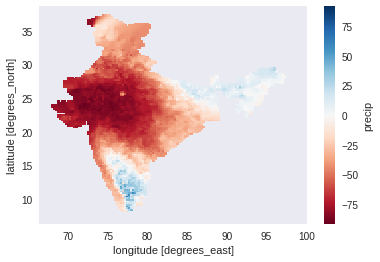

In [714]:
imd_anam.where(cmr_anam.precip <= -40).mean('time').precip.plot(cmap='RdBu')

In [706]:
arr = cmr_anam.where(cmr_anam.precip >= 40).precip.values

In [707]:
arr[~np.isnan(arr)].size/arr.size

0.21666666666666667

In [749]:
tfield_dict = {'abs': {}, 
            'anam': {}}

In [750]:
pentad_ds = {model : {'abs': {}, 
            'anam': {}} 
             for model in modelIndex}

In [751]:
cmr_fmean = {}

In [752]:
ABN_ds = {model : {'abs': {}, 
            'anam': {}} 
          for model in modelIndex}

In [753]:
ABN_cond = {model :  {} for model in modelIndex}

In [754]:
%%time
for model in modelIndex:
    var_name = getvarname(model, 'precip')
    time_name = gettimename(model, 'precip')
    
    f = make_pentad(getModelFile(model, 'precip'))
    pentad_ds[model]['abs'] = xr.open_dataset(f, chunks={time_name: 24})
    pentad_ds[model]['anam'] = (xr
                                .open_dataset(cdo.mulc('100',
                                                       input=f"-ydaydiv -ydaysub {f}"+\
                                                             f" -ydaymean {f} -ydaymean {f}",
                                   returnCDF=True),
                                             chunks={time_name: 24}))
                                
    cmr_fmean[model] = fldmean(sellonlatbox(pentad_ds[model]['anam'], 
                                [73, 82, 18, 28]))
    
    ABN_cond[model]['A'] = cmr_fmean[model][var_name] > 40
    ABN_cond[model]['B'] = cmr_fmean[model][var_name] < -40
    ABN_cond[model]['N'] = (cmr_fmean[model][var_name] >= -40) & (cmr_fmean[model][var_name] <= 40) 

    
    for spell in ['A', 'B', 'N']:
        for tfield in ['abs', 'anam']:
            ABN_ds[model][tfield][spell] = (pentad_ds[model][tfield]
                                            .where(ABN_cond[model][spell])
                                            .mean(time_name))                    

CPU times: user 956 ms, sys: 236 ms, total: 1.19 s
Wall time: 12.6 s


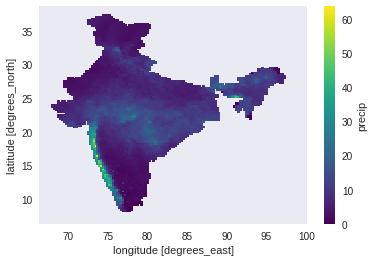

In [763]:
ABN_ds['IMD']['abs']['A'].precip.plot()

In [767]:
axn

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fad5b561fd0>,
      dtype=object)

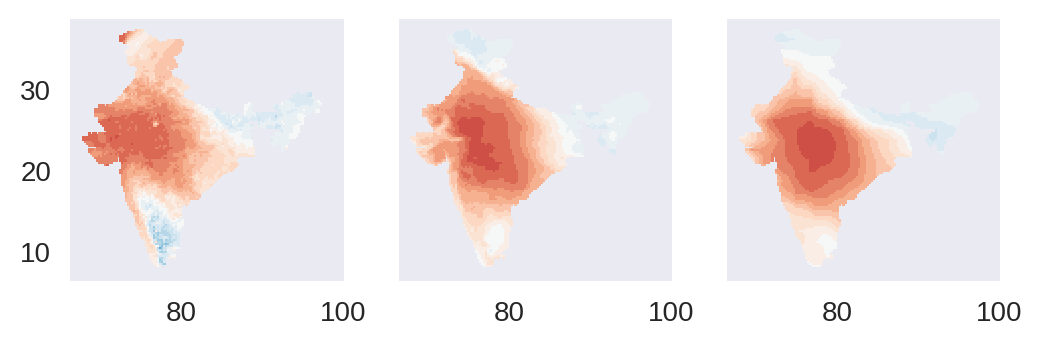

In [781]:
fig, axn = plt.subplots(1, 3, sharex=True, sharey=True,
                       dpi=200)

for ax, model in zip(axn, list(modelIndex)):
    ax.set_aspect('equal')
    var_name = getvarname(model, 'precip')
    
    plot = ABN_ds[model]['anam']['B'][var_name].plot(ax=ax, 
                                            levels=np.arange(-150, 150, 10),
                                                    cmap='RdBu')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plot.colorbar.remove()
    
fig.subplots_adjust(hspace=0.2, wspace=0.2)

In [784]:
for model in modelIndex:
    outdir = f"../data/{model}/precip/ABN"
    os.system(f'mkdir -p {outdir}')
    
    for spell in ['A', 'B', 'N']:
        for tfield in ['abs', 'anam']:
            outname = f"1971-2000_rm_ll25_{spell}_{tfield}.nc"
            ABN_ds[model][tfield][spell].to_netcdf(f"{outdir}/{outname}")

/home/abhi/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [803]:
df = ABN_ds['IMD']['abs']['A'].to_dataframe().reset_index().dropna()

/home/abhi/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


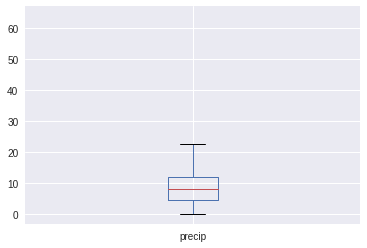

In [805]:
df.boxplot(column='precip')

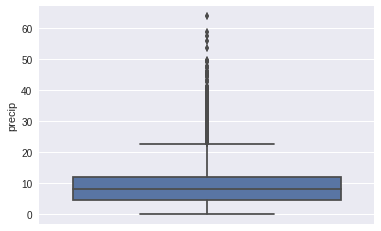

In [808]:
sns.boxplot(data=df, y='precip', showfliers=True)

In [928]:
arr1 = ABN_ds['IMD']['abs']['N']
arr2 = ABN_ds['PRECIS']['abs']['N']
arr3 = ABN_ds['HADGEM2-ES']['abs']['N']

arr1 = arr1.precip.values.reshape(129*135)
arr1 = arr1[~np.isnan(arr1)]

arr2 = arr2.precip.values.reshape(129*135)
arr2 = arr2[~np.isnan(arr2)]


arr3 = arr3.pr.values.reshape(129*135)
arr3 = arr3[~np.isnan(arr3)]


In [929]:
arr1.size


4964

In [931]:
np.corrcoef(arr1, arr3)

array([[1.        , 0.53151618],
       [0.53151618, 1.        ]])

### Distribution comparison during A and B spells

In [1326]:
def getComposite(spell, model, region=None, return_da=True, pentad_dict=pentad_ds, 
                var='precip', tfield='abs'):
    
    var_name = getvarname(model, var)
    da = pentad_dict[model][tfield].where(ABN_cond[model][spell])[var_name]
    da = da.rename({gettimename(model, var): 'time'})
        
    if region == 'Core Monsoon':
        da = sellonlatbox(da, [73, 82, 18, 28])

        
    
    return da

In [1336]:
pentad_ds_tmax = {model: {'abs': None, 'anam': None} 
                  for model in modelIndex}

In [1337]:
%%time
for model in modelIndex:
    var_name = getvarname(model, 'tmax')
    time_name = gettimename(model, 'tmax')
    
    f = make_pentad(getModelFile(model, 'tmax'))
    pentad_ds_tmax[model]['abs'] = xr.open_dataset(f, chunks={time_name: 24})
    pentad_ds_tmax[model]['anam'] = (xr
                                .open_dataset(cdo.ydaysub(input=f"{f}"+\
                                                             f" -ydaymean {f}",
                                   returnCDF=True),
                                             chunks={time_name: 24}))

CPU times: user 1.14 s, sys: 448 ms, total: 1.58 s
Wall time: 23.1 s


In [1364]:
levels = np.arange(-2, 2+(0.001), 10**(-3))

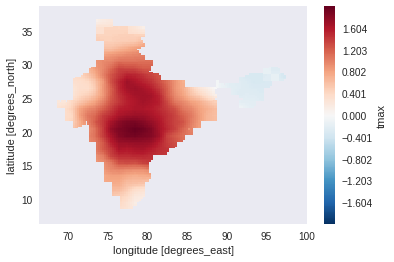

In [1413]:
test_ds = getComposite('B60', 'IMD', pentad_dict=pentad_ds_tmax, var='tmax', tfield='anam')

test_ds.mean(dim='time').plot(levels=levels)

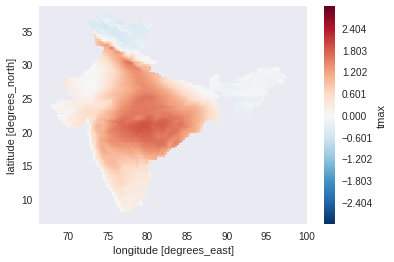

In [1430]:
test_ds = getComposite('B', 'PRECIS', pentad_dict=pentad_ds_tmax, var='tmax', tfield='anam')

test_ds.mean(dim='time').plot(levels=levels)

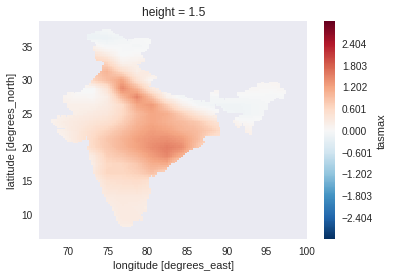

In [1428]:
test_ds = getComposite('B', 'HADGEM2-ES', pentad_dict=pentad_ds_tmax, var='tmax', tfield='anam')

test_ds.mean(dim='time').plot(levels=levels)

In [1435]:
ABN_cond['HADGEM2-ES']

{'A': <xarray.DataArray 'pr' (time: 720)>
 dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
 Coordinates:
   * time     (time) object 1971-06-03 12:00:00 ... 2000-09-28 12:00:00,
 'B': <xarray.DataArray 'pr' (time: 720)>
 dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
 Coordinates:
   * time     (time) object 1971-06-03 12:00:00 ... 2000-09-28 12:00:00,
 'N': <xarray.DataArray 'pr' (time: 720)>
 dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
 Coordinates:
   * time     (time) object 1971-06-03 12:00:00 ... 2000-09-28 12:00:00,
 'B60': <xarray.DataArray 'pr' (time: 720)>
 dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
 Coordinates:
   * time     (time) object 1971-06-03 12:00:00 ... 2000-09-28 12:00:00,
 'B75': <xarray.DataArray 'pr' (time: 720)>
 dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
 Coordinates:
   * time     (time) object 1971-06-03 12:00:00 ... 2000-09-28 12:00:00}

In [1582]:
def getconcatds_tmax(model, apply_tmean=True):
    time_name=gettimename(model, 'tmax')
    ds = getComposite('B', model, 
                 pentad_dict=pentad_ds_tmax, 
                 var='tmax', tfield='anam')
    
    try:
        ds = ds.drop('height')
    except Exception:
        pass
    
    if apply_tmean:
        return ds.mean('time')
    
    return ds

In [1449]:
getconcatds_tmax('HADGEM2-ES', False)

<xarray.DataArray 'tasmax' (time: 418, lat: 129, lon: 135)>
dask.array<shape=(418, 129, 135), dtype=float32, chunksize=(24, 129, 135)>
Coordinates:
  * time     (time) object 1971-06-03 12:00:00 ... 1989-07-18 12:00:00
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    units:             K
    comment:           daily-maximum near-surface (usually, 2 meter) air temp...
    original_name:     mo: m01s03i236
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    history:           2010-11-22T15:34:22Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [1583]:
tmax_B_ds = xr.concat([sellonlatbox(getconcatds_tmax(model, False), [73,82,18,28]).compute()
                      for model in modelIndex], 
                     dim=modelIndex)

In [1584]:
fldmean(tmax_B_ds)

<xarray.DataArray 'tmax' (model: 3, time: 1440)>
array([[      nan,       nan,       nan, ...,       nan,  1.205616,       nan],
       [      nan, -0.201999,       nan, ..., -0.274081,       nan,  0.350489],
       [      nan,  0.512634,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
  * time     (time) object 1971-06-03 00:00:00 ... 2000-09-28 12:00:00
  * model    (model) object 'IMD' 'PRECIS' 'HADGEM2-ES'

In [1587]:
tmax_df = tmax_B_ds.to_dataframe().reset_index().dropna()

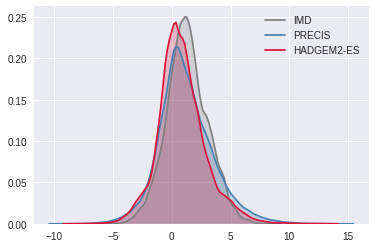

In [1588]:
for model in modelIndex:
    sns.kdeplot(data=tmax_df.loc[tmax_df.model == model].tmax, color=def_cols_d[model],
               shade=True, label=model)

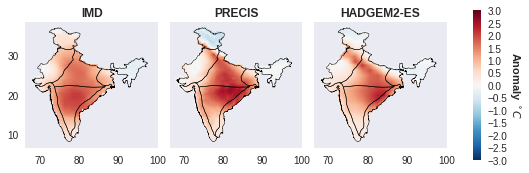

In [1426]:
ll, ul = -3, 3 
levels = np.arange(ll, ul+(0.001), 10**(-3))

g = tmax_B_ds.plot(col='model', levels=levels)

g.cbar.remove()
for ax in g.fig.axes:
    title = ax.get_title().replace('model = ', '')
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    shp.boundary.plot(edgecolor='black', ax=ax, linewidth=0.5)
    
g.add_colorbar()

g.cbar.set_label('Anomaly $^\circ C$', rotation=270, labelpad=15, fontweight='bold')
g.cbar.set_ticks(np.arange(ll, ul+.1, 0.5))

# g.fig.savefig("../plots/compare/tmax/Break-composite/Break-composite.png",
#              dpi=400, bbox_inches='tight')

In [1442]:
sellonlatbox(tmax_B_ds, [73, 82, 18, 28]).mean(dim=['lat', 'lon'])

<xarray.DataArray 'tmax' (model: 3)>
array([1.303619, 1.216963, 0.863461], dtype=float32)
Coordinates:
  * model    (model) object 'IMD' 'PRECIS' 'HADGEM2-ES'

In [1409]:
arr.min()

-99.30355

In [1422]:
arr[arr< -75].size/arr.size

0.10972222222222222

In [1423]:
for model in modelIndex:
    var_name = getvarname(model, 'precip')
    ABN_cond[model]['B75'] = cmr_fmean[model][var_name] < -75

In [1388]:
cmr_fmean

In [973]:
spellIndex = pd.Index(['A', 'B', 'N'], name='spell')


In [989]:
%%time
composite_ds = xr.concat([xr.concat([getComposite(spell, model, 'Core Monsoon')
                                   for spell in spellIndex], dim=spellIndex)
                          for model in modelIndex], 
                         dim=modelIndex)

CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 208 ms


In [993]:
composite_df = composite_ds.to_dataframe().reset_index()

In [ ]:
conv2pd_dt()

In [998]:
composite_df.time = composite_df.time.apply(lambda x: conv2pd_dt(x))

In [1000]:
composite_df.dropna(inplace=True)

In [1003]:
composite_df.head()

,model,spell,time,lat,lon,precip
0,IMD,A,1971-06-03,18.0,73.00,42.848785
1,IMD,A,1971-06-03,18.0,73.25,58.099728
2,IMD,A,1971-06-03,18.0,73.50,76.295929
3,IMD,A,1971-06-03,18.0,73.75,19.266478
4,IMD,A,1971-06-03,18.0,74.00,10.177290


In [1004]:
composite_df.to_pickle("../pickles/Analysis-Annual-cycle/composite_df.pkl")

In [1027]:
def_cols

['gray', 'steelblue', 'crimson']

In [1030]:
def_cols_d = dict(zip(list(modelIndex), def_cols))

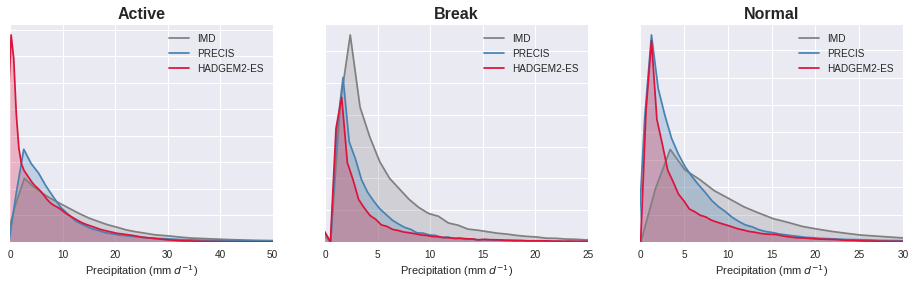

In [1542]:
fig, axn = plt.subplots(1, 3, figsize=(16, 4))

titles = {'A': 'Active',
         'B': 'Break', 
         'N': 'Normal'}

xlims = {'A': (0, 50),
        'B': (0, 25),
        'N': (0, 30)}

for ax, spell in zip(axn, list(spellIndex)):
    for model in modelIndex:

        sns.kdeplot(composite_df.loc[(composite_df.model == model)
                                    & (composite_df.spell == spell)].precip, shade=True, 
                   ax=ax, label=model, color=def_cols_d[model])
        
    ax.set_title(titles[spell], fontweight='bold', fontsize=16)
    
    ax.set_xlim(*xlims[spell])
    ax.set_yticklabels([])
    ax.set_xlabel('Precipitation (mm $d^{-1}$)')
    
fig.savefig("../plots/compare/precip/ABN_dist/Core Monsoon.png", dpi=400, 
           bbox_inches='tight')

CPU times: user 792 ms, sys: 32 ms, total: 824 ms
Wall time: 821 ms


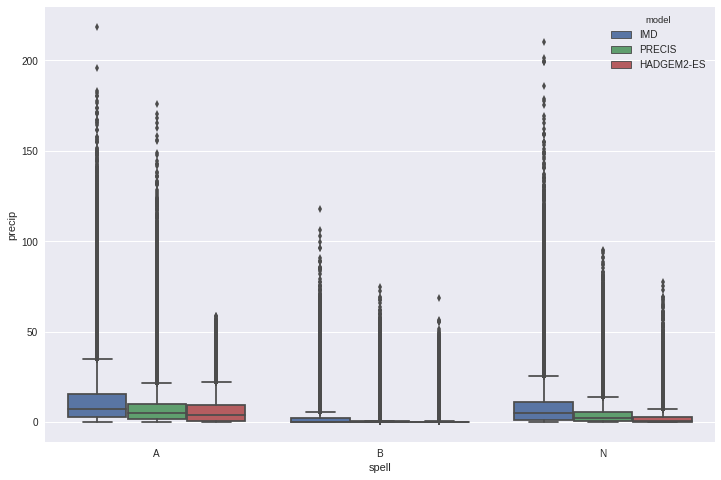

In [1006]:
%%time
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=composite_df, x='spell', y='precip', hue='model')

In [965]:
ds_A = getComposite('A', 'IMD', 'Core Monsoon')

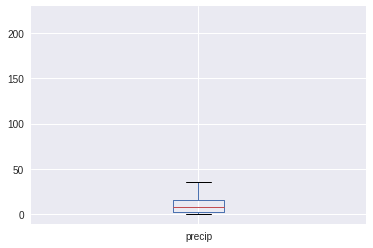

In [957]:
df_A.dropna().boxplot(column='precip')

In [936]:
pentad_ds['IMD']['abs'].where(ABN_cond['IMD']['A'])

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 129, lon: 135, time: 720)
Coordinates:
  * time       (time) object 1971-06-03 00:00:00 ... 2000-09-28 00:00:00
  * lon        (lon) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(720, 2), chunksize=(24, 2)>
    precip     (time, lat, lon) float32 dask.array<shape=(720, 129, 135), chunksize=(24, 129, 135)>
Attributes:
    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Mon Jan 21 18:43:46 2019: cdo -O timselmean,5 -selseas,JJAS...
    NCO:          4.7.3
    CDO:          Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/...

In [933]:
ABN_cond

{'IMD': {'A': <xarray.DataArray 'precip' (time: 720)>
  dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
  Coordinates:
    * time     (time) object 1971-06-03 00:00:00 ... 2000-09-28 00:00:00,
  'B': <xarray.DataArray 'precip' (time: 720)>
  dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
  Coordinates:
    * time     (time) object 1971-06-03 00:00:00 ... 2000-09-28 00:00:00,
  'N': <xarray.DataArray 'precip' (time: 720)>
  dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
  Coordinates:
    * time     (time) object 1971-06-03 00:00:00 ... 2000-09-28 00:00:00},
 'PRECIS': {'A': <xarray.DataArray 'precip' (t: 720)>
  dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
  Coordinates:
    * t        (t) object 1971-06-03 12:00:00 ... 2000-09-28 12:00:00,
  'B': <xarray.DataArray 'precip' (t: 720)>
  dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
  Coordinates:
    * t        (t) object 1971-06-03 12:00:00 ... 2000-09-28 12:00:00,
  'N': <xarray.DataArray 'precip' 

In [1060]:
ABN_cond

{'IMD': {'A': <xarray.DataArray 'precip' (time: 720)>
  dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
  Coordinates:
    * time     (time) object 1971-06-03 00:00:00 ... 2000-09-28 00:00:00,
  'B': <xarray.DataArray 'precip' (time: 720)>
  dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
  Coordinates:
    * time     (time) object 1971-06-03 00:00:00 ... 2000-09-28 00:00:00,
  'N': <xarray.DataArray 'precip' (time: 720)>
  dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
  Coordinates:
    * time     (time) object 1971-06-03 00:00:00 ... 2000-09-28 00:00:00},
 'PRECIS': {'A': <xarray.DataArray 'precip' (t: 720)>
  dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
  Coordinates:
    * t        (t) object 1971-06-03 12:00:00 ... 2000-09-28 12:00:00,
  'B': <xarray.DataArray 'precip' (t: 720)>
  dask.array<shape=(720,), dtype=bool, chunksize=(24,)>
  Coordinates:
    * t        (t) object 1971-06-03 12:00:00 ... 2000-09-28 12:00:00,
  'N': <xarray.DataArray 'precip' 

In [1076]:
arr = cmr_fmean['HADGEM2-ES'].pr.where(ABN_cond['HADGEM2-ES']['A']).values

arr[~np.isnan(arr)].size/arr.size

0.20277777777777778

In [1134]:
drizzle = {}

In [1144]:
for model in modelIndex[1:]:
    cmd = f"-sub -timsum -lec,1 {fpaths[model]} "
    cmd += f"-timsum -lec,1 {fpaths['IMD']}"
    drizzle[model] = cdo.timsum(input=cmd,
                               returnCDF=True)
    

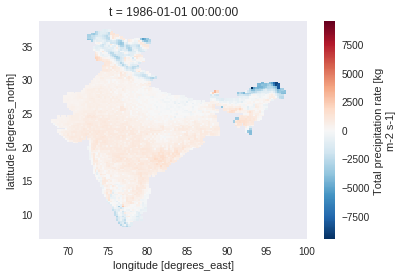

In [1146]:
xr.open_dataset(drizzle['PRECIS']).precip.isel(t=0).plot()

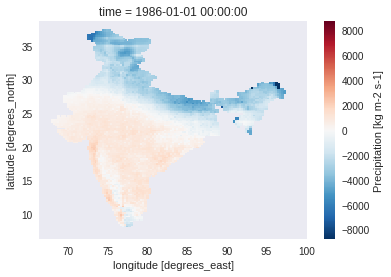

In [1147]:
xr.open_dataset(drizzle['HADGEM2-ES']).pr.isel(time=0).plot()

In [1151]:
rmse_ds1 = xr.open_dataset('/home/abhi/Documents/mygit/GCM_RCM/data/PRECIS_IMD/precip/RMSE/1971-2000_rm_ll25_JJAS_RMSE.nc')

In [1158]:
subsetbygdf_new(rmse_ds1, shp, 'Region').precip.mean(dim='t').to_dataframe()

,precip
region,
Northern,2.428983
North East,6.721655
North West,3.372528
Central,4.596187
Inner Peninsular,3.878548
West Coast,6.446262
East Coast,3.268961
Core Monsoon,4.780663
India,4.454656


In [1159]:
rmse_ds2 = xr.open_dataset('/home/abhi/Documents/mygit/GCM_RCM/data/HADGEM2-ES_IMD/precip/RMSE/1971-2000_rm_ll25_JJAS_RMSE.nc')

In [1160]:
subsetbygdf_new(rmse_ds2, shp, 'Region').pr.mean(dim='time').to_dataframe()

,pr
region,
Northern,2.585174
North East,6.139347
North West,3.192448
Central,4.989213
Inner Peninsular,4.704146
West Coast,8.462543
East Coast,3.961590
Core Monsoon,5.597978
India,4.894691


In [1161]:
getCompareFile = lambda m1, m2, var, metric, seas: \
f'/home/abhi/Documents/mygit/GCM_RCM/data/{m1}_{m2}/{var}/{metric}/1971-2000_rm_ll25_{seas}_{metric}.nc'

In [1165]:
seasIndex = pd.Index(['Annual', 'JJAS', 'ON', 'DJF', 'MAM'], name='seas')
metricIndex = pd.Index(['BIAS', 'RMSE', 'timcor'], name='metric')


Index(['precip', 'tmean', 'tmax', 'tmin'], dtype='object', name='var_name')

In [1211]:
def getconcatds(m1, m2, var, metric, seas, subset=False):
    var_name = getvarname(m1, var)
    time_name = gettimename(m1, var)
    
    ds = (xr
            .open_dataset(getCompareFile(m1, m2, 
                                         var, metric, 
                                         seas)))
    
    if var == 'tmax' and model == 'HADGEM2-ES':
        too_less =  ds[var_name] > -60
        too_much =  ds[var_name] < 60

        ds[var_name] =  ds[var_name].where(too_less & too_much)
        
        
    ds = ds[var_name].mean(dim=time_name)
    
    try:
        ds = ds.drop('height')
    except Exception:
        pass
    
    if subset:
        return subsetbygdf_new(ds, shp, 'Region')
    


    return ds

In [1179]:
xr.open_dataset(getCompareFile('PRECIS', 'IMD', 'precip', 'BIAS', 'Annual'))

<xarray.Dataset>
Dimensions:  (bnds: 2, lat: 129, lon: 135, t: 1)
Coordinates:
  * t        (t) object 1986-01-01 00:00:00
  * lon      (lon) float32 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
Dimensions without coordinates: bnds
Data variables:
    t_bnds   (t, bnds) float64 ...
    precip   (t, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Jan 14 11:42:51 2019: cdo -O sub ../data/PRECIS/precip/...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/...

In [1212]:
metric_ds = xr.concat([xr.concat([xr.concat([xr.concat([getconcatds(model, 'IMD', var, metric, seas)
                          for seas in seasIndex], dim=seasIndex)
                for metric in metricIndex], dim=metricIndex)
                 for var in varIndex], dim=varIndex)
       for model in modelIndex[1:]], dim=modelIndex[1:]).to_dataset().rename({'precip': 'variable'})

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site

In [1213]:
%%time
metric_ds = subsetbygdf_new(metric_ds, shp, 'Region') 

CPU times: user 948 ms, sys: 24 ms, total: 972 ms
Wall time: 971 ms


In [1214]:
metric_df = metric_ds.variable.to_dataframe().reset_index()

In [1235]:
def selmetric_df(var, metric, seas, drop_north=True):
    return metric_df.loc[((metric_df.var_name == var)&
                          (metric_df.metric == metric)&
                         (metric_df.seas == seas) &
                         (metric_df.region != 'Northern'))]

In [1236]:
selmetric_df('precip', 'BIAS', 'Annual').head()

,region,model,var_name,metric,seas,variable
120,North East,PRECIS,precip,BIAS,Annual,-1.074243
180,North East,HADGEM2-ES,precip,BIAS,Annual,-0.028635
240,North West,PRECIS,precip,BIAS,Annual,-0.986716
300,North West,HADGEM2-ES,precip,BIAS,Annual,-0.451775
360,Central,PRECIS,precip,BIAS,Annual,-1.278889


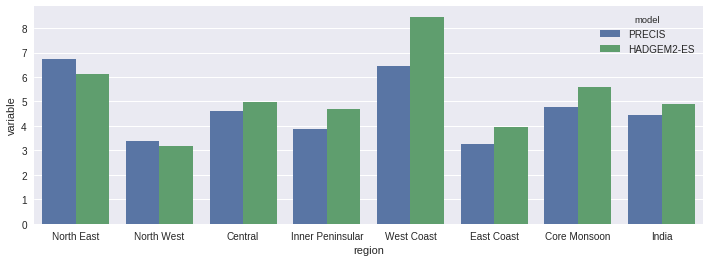

In [1243]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='region', y='variable', hue='model', 
           data=selmetric_df('precip', 'RMSE', 'JJAS'))

In [1245]:
pd_threshIndex = pd.Index([f'pd_{thresh}mm' for thresh in [1, 5, 10, 20, 30, 50, 100, 200]],
                         name='pd_thresh')

In [1251]:
var_name = 'precipitation_days_index_per_time_period'

In [1255]:
xr.open_dataset(getFile('PRECIS', 'precip', 'pd_10mm', 'JJAS'))[var_name].mean(dim='time')

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'precipitation_days_index_per_time_period' (lat: 129, lon: 135)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5

In [1256]:
pd_threshds = xr.concat([xr.concat([(xr
                        .open_dataset(getFile(model, 'precip', 
                                              metric, 'JJAS'))[var_name]
                        .mean(dim='time'))
                       for metric in pd_threshIndex], dim=pd_threshIndex)
                       for model in modelIndex],
                      dim=modelIndex)

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [1262]:
pd_threshdf = subsetbygdf_new(pd_threshds, shp, 'Region').to_dataframe().reset_index()

In [ ]:
def sel_threshdf(region, )

In [1264]:
pd_threshdf.head()

,region,model,pd_thresh,precipitation_days_index_per_time_period
0,Northern,IMD,pd_1mm,31.571745
1,Northern,IMD,pd_5mm,15.283991
2,Northern,IMD,pd_10mm,8.416129
3,Northern,IMD,pd_20mm,3.486918
4,Northern,IMD,pd_30mm,1.856631


In [1317]:

def thresh_plot(region, savefig=False):
    fig, ax = plt.subplots(figsize=(12, 4))
    df_plot = pd_threshdf.loc[(pd_threshdf.region == region) & (pd_threshdf.pd_thresh != "pd_200mm")]
    sns.barplot(data=df_plot,
                x='pd_thresh', y='precipitation_days_index_per_time_period',
                hue='model', palette=def_cols, ax=ax)

    s = pd.Series(df_plot.pd_thresh.unique()).str.replace('pd_', '> ')

    ax.set_xticklabels(s, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('% days', fontweight='bold')
    ax.set_title(region, fontweight='bold', fontsize=16)

    leg = ax.get_legend()
    leg.set_title('')
    
    if savefig:
        out_name = f"../plots/compare/precip/pd_thresh/{region}.png"
        fig.savefig(out_name, dpi=400, bbox_inches='tight')
        plt.close(fig)

In [ ]:
sel_df

In [1633]:
region

'Inner Penninsular'

In [1632]:
df_plot.loc[df_plot.region == region]

,region,model,pd_thresh,precipitation_days_index_per_time_period


In [ ]:
ax.tra

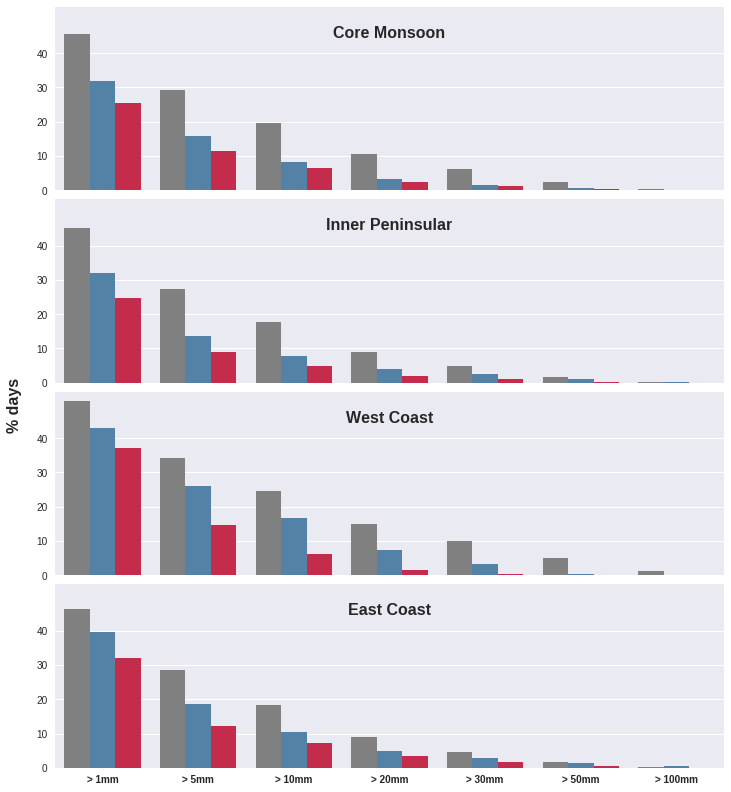

In [1669]:
df_plot = pd_threshdf.loc[(pd_threshdf.pd_thresh != "pd_200mm")]
regions = ['Core Monsoon', 'Inner Peninsular',
                           'West Coast', 'East Coast']

fig, axn = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(12, 14))

fig.subplots_adjust(hspace=0.05, wspace=0)
s = pd.Series(df_plot.pd_thresh.unique()).str.replace('pd_', '> ')

for (i, ax), region in zip(enumerate(axn), regions):
    selthreshdf = df_plot.loc[df_plot.region == region]
    sns.barplot(data=selthreshdf,
               x='pd_thresh', y='precipitation_days_index_per_time_period',
                hue='model', palette=def_cols, ax=ax) 
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.text(0.5, 0.90, region, transform=ax.transAxes,
           horizontalalignment='center',
           verticalalignment='top', fontweight='bold', fontsize=16)
    
    ax.set_yticks(range(0, 50, 10))
    if i == 3:
        ax.set_xticklabels(s, fontweight='bold')
        
    elif i == 1:
        pass
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend().remove()
    
    
fig.text(0.07, 0.5, '% days', rotation=90,
        fontsize=16, fontweight='bold')
outdir = '../plots/compare/precip/combined_threshplot'
os.system(f'mkdir -p {outdir}')
fig.savefig(f"{outdir}/{'_'.join(regions)}.png", 
            dpi=400, bbox_inches='tight')

In [1653]:
ax.get_xlim()

(-0.5, 6.5)

In [1319]:
for region in regionIndex_new:
    thresh_plot(region, True)

In [1286]:
t = ax.get_xticklabels()[0]

In [1619]:
list(regionIndex_new)

['Northern',
 'North East',
 'North West',
 'Central',
 'Inner Peninsular',
 'West Coast',
 'East Coast',
 'Core Monsoon',
 'India']

In [1451]:
pentad_ds_tmax['HADGEM2-ES']

{'abs': <xarray.Dataset>
 Dimensions:    (bnds: 2, lat: 129, lon: 135, time: 682)
 Coordinates:
   * time       (time) object 1971-06-03 12:00:00 ... 2000-09-29 12:00:00
   * lon        (lon) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
   * lat        (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
     height     float64 ...
 Dimensions without coordinates: bnds
 Data variables:
     time_bnds  (time, bnds) float64 dask.array<shape=(682, 2), chunksize=(24, 2)>
     tasmax     (time, lat, lon) float32 dask.array<shape=(682, 129, 135), chunksize=(24, 129, 135)>
 Attributes:
     CDI:                    Climate Data Interface version 1.9.5 (http://mpim...
     Conventions:            CF-1.4
     history:                Wed Jan 23 16:44:01 2019: cdo -O timselmean,5 -se...
     source:                 HadGEM2-ES (2009) atmosphere: HadGAM2 (N96L38); o...
     institution:            Met Office Hadley Centre, Fitzroy Road, Exeter, D...
     institute_id:           

In [1470]:
cmd = lambda model, var: f"-yearmean -ymonsub {getFile(model, var, 'monmean')}"+\
                         f" {getFile(model, var, 'ymonmean')}"


In [1471]:
cmd('IMD', 'precip')

'-yearmean -ymonsub ../data/IMD/precip/monmean/1971-2000_rm_ll25_monmean.nc ../data/IMD/precip/ymonmean/1971-2000_rm_ll25_ymonmean.nc'

In [1484]:
anam_corr = cdo.timcor(input=f"{cmd('IMD', 'tmax')} {cmd('PRECIS', 'tmax')}",
                      returnCDF=True)

In [1485]:
anam_ds = xr.open_dataset(anam_corr)

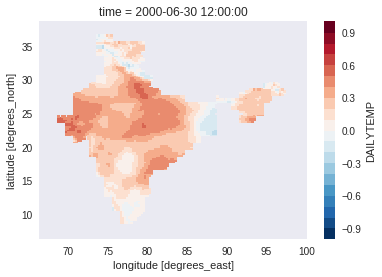

In [1488]:
anam_ds.tmax.plot(levels=np.arange(-1, 1.1, 0.1))

In [1490]:
subsetbygdf_new(anam_ds, shp, 'Region').tmax.mean('time').to_dataframe()

,tmax
region,
Northern,0.088170
North East,0.120295
North West,0.330698
Central,0.369461
Inner Peninsular,0.230473
West Coast,0.213900
East Coast,0.211464
Core Monsoon,0.336634
India,0.252190
